# Exercise 6

In this exercise, we will implement an autoencoder.

In [1]:
import torch
import torch.nn as nn

We will once again use the MNIST dataset (recognition of handwritten digits):

In [2]:
from torchvision.datasets import MNIST

train_data = MNIST('./mnist', download=True, train=True)
val_data = MNIST('./mnist', download=True, train=False)

We all know by now how the MNIST data looks, but just for completeness:

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

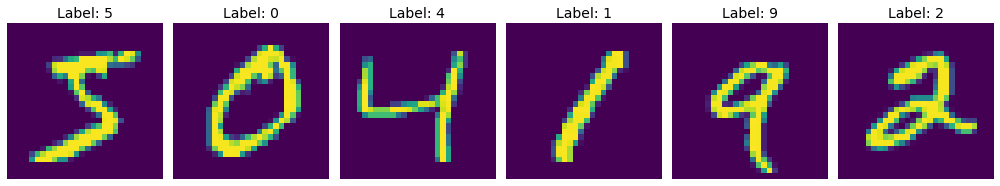

In [4]:
fig, axes = plt.subplots(1, 6, figsize=(14, 14))
for i in range(6):
    image, label = train_data[i]
    ax = axes[i]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"Label: {label}", fontdict={"fontsize": 14})
plt.tight_layout()
plt.show()

## Dataloader

The dataloader is also nothing new, we will normalize the images so that they are easier to process for the network:

In [5]:
from torchvision.transforms import ToTensor, Compose, Normalize, Lambda
from torch.utils.data import DataLoader

train_transform = Compose([
    ToTensor(),
    Normalize(mean=(0.1306,), std=(0.3081,)),
    Lambda(lambda x: nn.functional.dropout(x, p=0.3))
])

val_transform = Compose([
    ToTensor(),
    Normalize(mean=(0.1306,), std=(0.3081,))
])

train_data_torch = MNIST('./mnist', download=True, train=True, transform=train_transform)
val_data_torch = MNIST('./mnist', download=True, train=False, transform=val_transform)

In [6]:
BATCH_SIZE = 128
train_loader = DataLoader(train_data_torch, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data_torch, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

### Network

The autoencoder that we want to implement shall have the following structure:

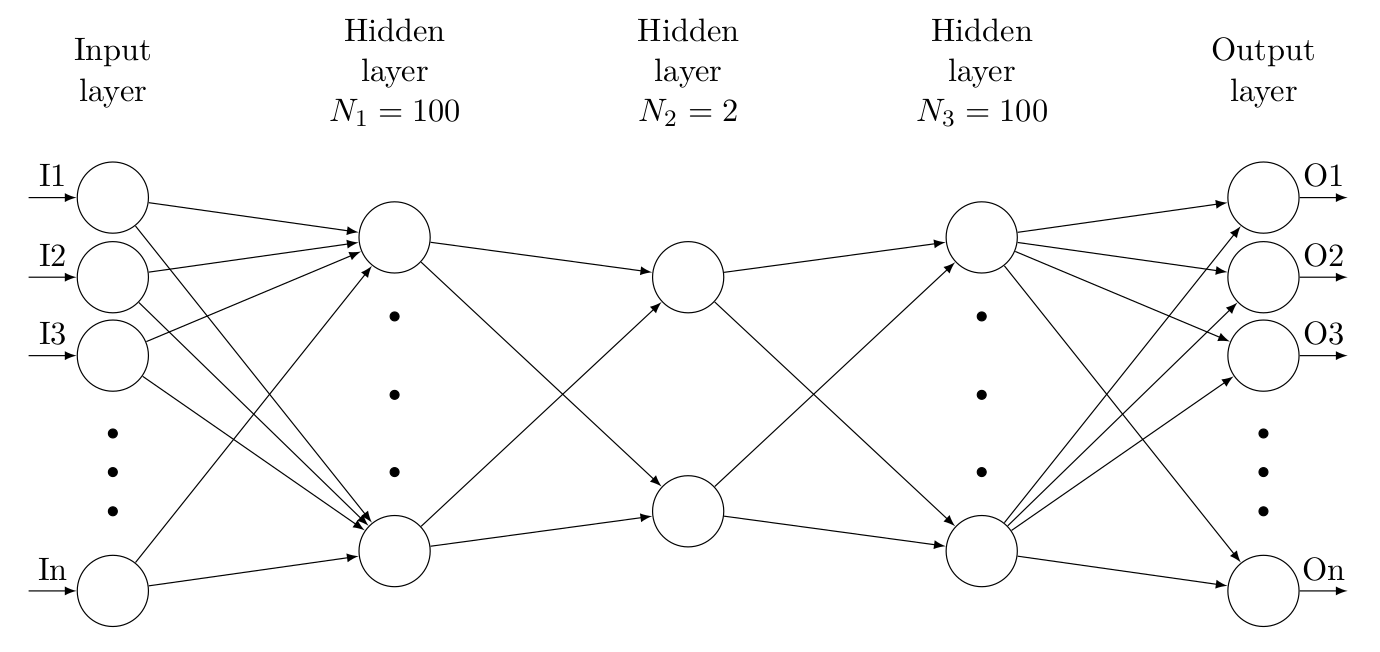

This means, the encoder has two linear layers and the decoder has two linear layers as well. The latent representation created by the encoder is just two-dimensional. Use sigmoid activations after the linear layers with 100 outputs (but not after the final encoder layer).

Your first task is to complete the implementation of the autoencoder in the below class:

In [7]:
import torch.nn.functional as F
from functools import reduce


class AutoEncoder(nn.Module):
    def __init__(self, input_size):
        super(AutoEncoder, self).__init__()
        self.HIDDEN_SIZE1 = 100
        self.HIDDEN_SIZE = 2

        input_size = input_size if type(input_size) != int else (input_size,)
        self.input_size = input_size
        # calculate the number of features of the flattened array (in our case: 28*28)
        in_size = reduce(lambda x, y: x*y, input_size)
        
        self.encoder = nn.Linear(in_size, self.HIDDEN_SIZE1)
        self.encoder_sigm = torch.nn.Sigmoid()
        self.latent = nn.Linear(self.HIDDEN_SIZE1, self.HIDDEN_SIZE)
        self.decoder = nn.Linear(self.HIDDEN_SIZE, self.HIDDEN_SIZE1)
        self.decoder_sigm = nn.Sigmoid()
        self.out = nn.Linear(self.HIDDEN_SIZE1, in_size)
        
    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)

    def encode(self, x):
        # flatten the input image into a single vector
        x = x.view(x.shape[0], -1)
        x = self.encoder(x)
        x = self.encoder_sigm(x)
        x = self.latent(x)        
        return x

    def decode(self, x):
        x = self.decoder(x)
        x = self.decoder_sigm(x)
        x = self.out(x)
        
        # finally, reshape the features into an image of the same size as the original input
        x = x.view((x.shape[0], *self.input_size))
        return x

## Training

In [8]:
model = AutoEncoder(input_size=(1, 28, 28))
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
LR = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=0.0001)

The training loop is also not very different from the previous exercises, but now we use MSE loss to compare the reconstructed image from the decoder with the original image (reconstruction loss).

In [9]:
from torch.nn.functional import mse_loss
import numpy as np
import tqdm

NUM_EPOCHS = 10

train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    # perform training followed by validation
    for mode, loader in [
        ("train", train_loader),
        ("val", val_loader)
    ]:
        # progressbar setup
        num_batches = len(loader)
        pbar = tqdm.tqdm(total=num_batches, desc=f"{mode} epoch {epoch}")

        if mode == "train":
            model.train() # do calculate gradients for training mode
        else:
            model.eval() # do not calculate gradients in validation mode

        # initial values of the metrics (loss, accurracy)
        runningLoss = 0.
        correct_predictions = 0
        # total number of images that were processed
        total_samples = 0
        
        # loop over the data
        for i_batch, batch in zip(range(num_batches), loader):
            images, labels = batch
            # move tensors to the correct device
            images = images.to(device)
            labels = labels.to(device)

            # run the model
            predictions = model(images)

            # loss calculation
            loss = mse_loss(predictions, images)

            # calculate the metrics for the progress bar
            num_batch_samples = len(images)
            runningLoss += loss.item() * num_batch_samples
            total_samples += num_batch_samples
            
            pbar.update(1)
            pbar.set_postfix({
                "loss": runningLoss / total_samples
            })

            # weight update
            if mode == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        epoch_loss = runningLoss / total_samples
        if mode == "train":
            train_losses.append(epoch_loss)
        else:
            val_losses.append(epoch_loss)

        pbar.close()

val epoch 9: 100%|██████████| 79/79 [00:01<00:00, 58.06it/s, loss=0.493]


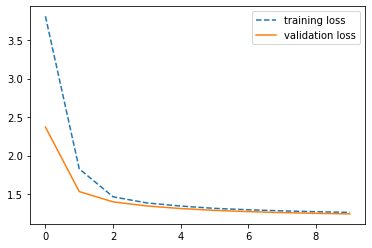

In [14]:
plt.plot(train_losses, '--', label="training loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

plt.show()

## Visualizing results

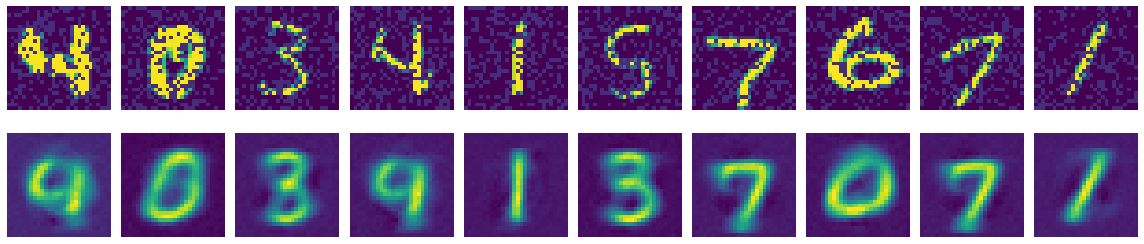

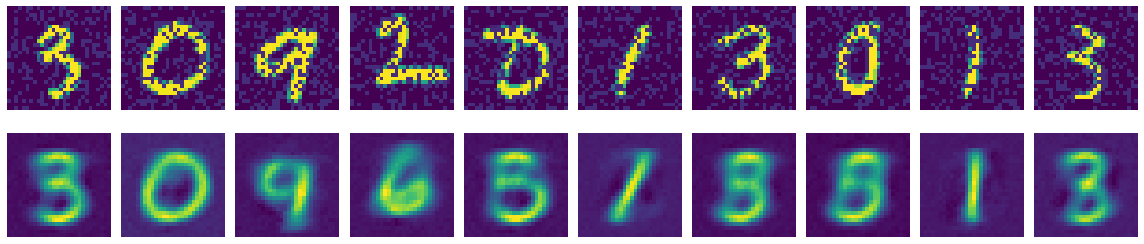

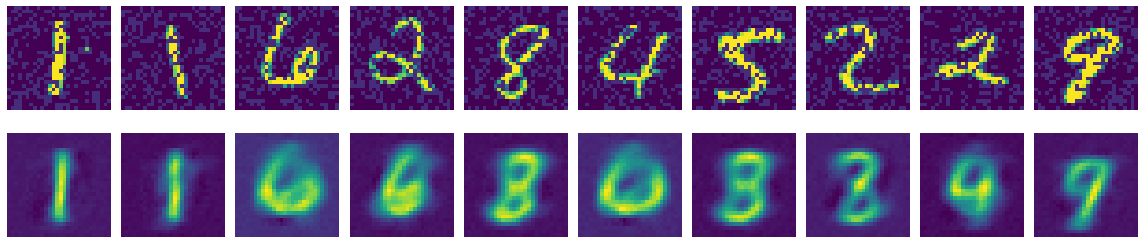

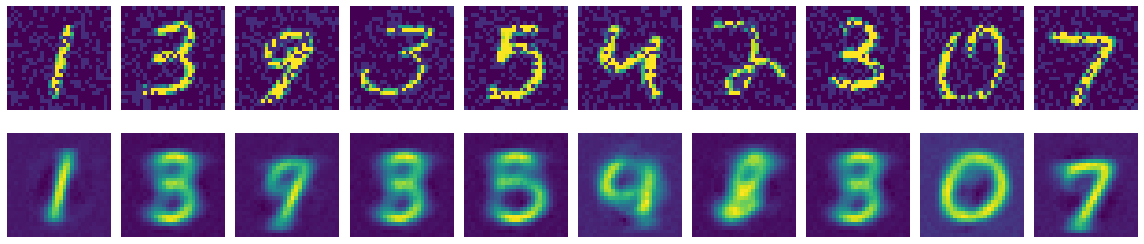

In [15]:
from torchvision.transforms.functional import to_pil_image
from math import ceil

n_samples_per_row = 10
image_samples, label_samples = next(train_loader.__iter__())
model.eval()
predictions = model(image_samples.to(device)).cpu()

n_rows = ceil(len(image_samples)/n_samples_per_row)
n_rows = min(4, n_rows)
for row in range(n_rows):
    subset = slice(row*n_samples_per_row, (row+1)*n_samples_per_row)
    images = image_samples[subset]
    labels = label_samples[subset]
    preds = predictions[subset]
    fig, axes = plt.subplots(2, len(images), figsize=(16, 4))
    for ax, image, prediction in zip(np.array(axes).transpose(), images, preds):
        ax1, ax2 = ax
        ax1.set_axis_off()
        ax1.imshow((image + 0.5).detach().numpy()[0])
        ax2.set_axis_off()
        ax2.imshow((prediction + 0.5).detach().numpy()[0])
    plt.tight_layout()
    plt.axis('off')
    plt.show()

As we can see, the autoencoder can encode the information which number an image represents, and then create an image showing the number, using only the latent representation generated by the encoder. This works better for some numbers such as 1, 7 or 0, and worse for numbers such as 2, 3 or 4. As we chose a HIDDEN_SIZE of 2, we can visualize the features that the autoencoder generates to encode the image:

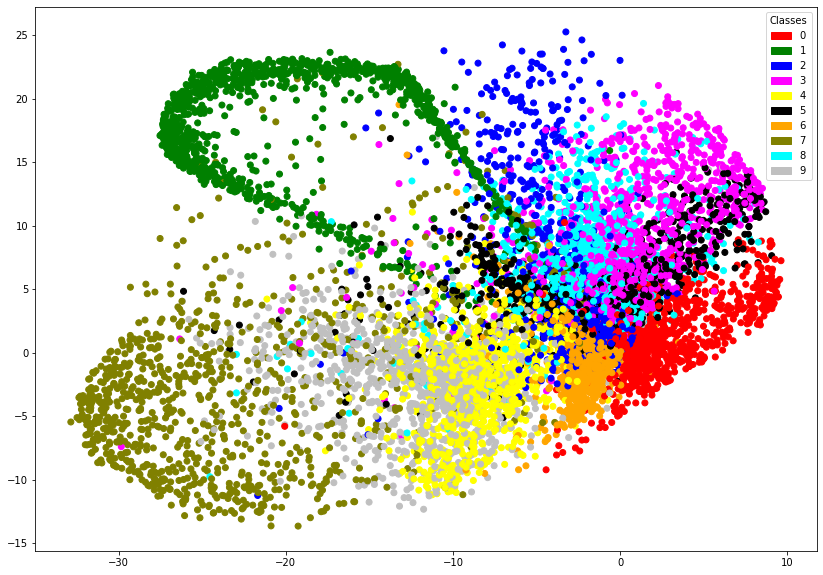

In [12]:
from itertools import islice
import matplotlib.patches as mpatches

# If we have just 2 hidden features, we can plot them:
if model.HIDDEN_SIZE == 2:
    x = []
    y = []
    c = []
    colors = np.array(['red', 'green', 'blue', 'magenta', 'yellow', 'black', 'orange', 'olive', 'aqua', 'silver'])

    # get a few batches and plot the feature distribution
    for image_samples, label_samples in val_loader:
        hidden = model.encode(image_samples.to(device)).cpu().detach().numpy()
        x += hidden[:, 0].flatten().tolist()
        y += hidden[:, 1].flatten().tolist()
        c += colors[label_samples.numpy()].tolist()
        
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.scatter(x, y, c=c)
    ax.legend(handles=[mpatches.Patch(color=c, label=str(i), fill=True) for i, c in enumerate(colors)], loc="upper right", title="Classes")
    plt.show()

We can see that e.g. the samples belonging to the `1` class are mostly separated from the other classes, whereas it seems that the class `5` is not as easy to distinguish from the other classes for the network, as its samples are more mixed with samples from the other classes. From this, we can directly see which classes appear similar to each other for the network.

Task: How can we improve this, such that the network can distinguish the numbers more easily and better reconstruct the image? Write your answers here:
 - Increase the dimension of the latent space to be able to encode more information
 - Add a regularizer to avoid overfitting
 - Increase the capacity of the model by adding more neurons/layers (in combination with regularization or dropout)

## Task: Classifier

 - Now that we have an autoencoder that can "compress" the information in the images, we can train a classifier that predicts the image label from the encoded representation. Implement a classifier network that consists of a linear layer with a softmax activation, then train it using a training loop with a cross_entropy loss. Remember that if you want to freeze the weights of the autoencoder (as we only want to train the classifier), you can use `model.eval()`.
 - Bonus task: Implement your suggestion for improving the autoencoder from above. If it works, it should also improve the accuracy of the classifier.

In [13]:
from torch.nn.functional import nll_loss

classifier = nn.Sequential(
    nn.Linear(2, 10),
    nn.LogSoftmax()
)

classifier.to(device)
model.to(device)

LR = 0.001
optimizer = torch.optim.Adam(classifier.parameters(), lr=LR, weight_decay=0.0001)

NUM_EPOCHS = 10

train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    # perform training followed by validation
    for mode, loader in [
        ("train", train_loader),
        ("val", val_loader)
    ]:
        # progressbar setup
        num_batches = len(loader)
        pbar = tqdm.tqdm(total=num_batches, desc=f"{mode} epoch {epoch}")

        if mode == "train":
            classifier.train() # do calculate gradients for training mode
        else:
            classifier.eval() # do not calculate gradients in validation mode

        # initial values of the metrics (loss, accurracy)
        runningLoss = 0.
        correct_predictions = 0
        # total number of images that were processed
        total_samples = 0
        
        # loop over the data
        for i_batch, batch in zip(range(num_batches), loader):
            images, labels = batch
            # move tensors to the correct device
            images = images.to(device)
            latent = model.encode(images)
            labels = labels.to(device)
            # run the model
            predictions = classifier(latent)
            # loss calculation
            loss = nll_loss(predictions, labels)

            # calculate the metrics for the progress bar
            num_batch_samples = len(images)
            runningLoss += loss.item() * num_batch_samples
            total_samples += num_batch_samples
            
            pbar.update(1)
            pbar.set_postfix({
                "loss": runningLoss / total_samples
            })

            # weight update
            if mode == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        epoch_loss = runningLoss / total_samples
        if mode == "train":
            train_losses.append(epoch_loss)
        else:
            val_losses.append(epoch_loss)

        pbar.close()

train epoch 0:   0%|          | 0/469 [00:00<?, ?it/s]/home/paul/Documents/Uni/Lectures/DeepLearning/DeepLearning/lib/python3.8/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
val epoch 9: 100%|██████████| 79/79 [00:01<00:00, 54.94it/s, loss=1.24]


## Task: Denoising autoencoder

Copy this notebook and rename it to work on the following:

Autoencoders without regularization can suffer from overfitting. Denoising autoencoders can learn to extract features which are robust to small changes in the input data, because they are trained with additive noise. Now, implement another autoencoder with just one hidden layer with N = 100 neurons in the encoder and one output layer for the decoder. Then, apply binary noise at the encoder inputs (randomly set 30% of the inputs to 0). Visualize the encoder input and output with a few samples from the validation set (see below example image). Again, train a classification network after training the autoencoder.

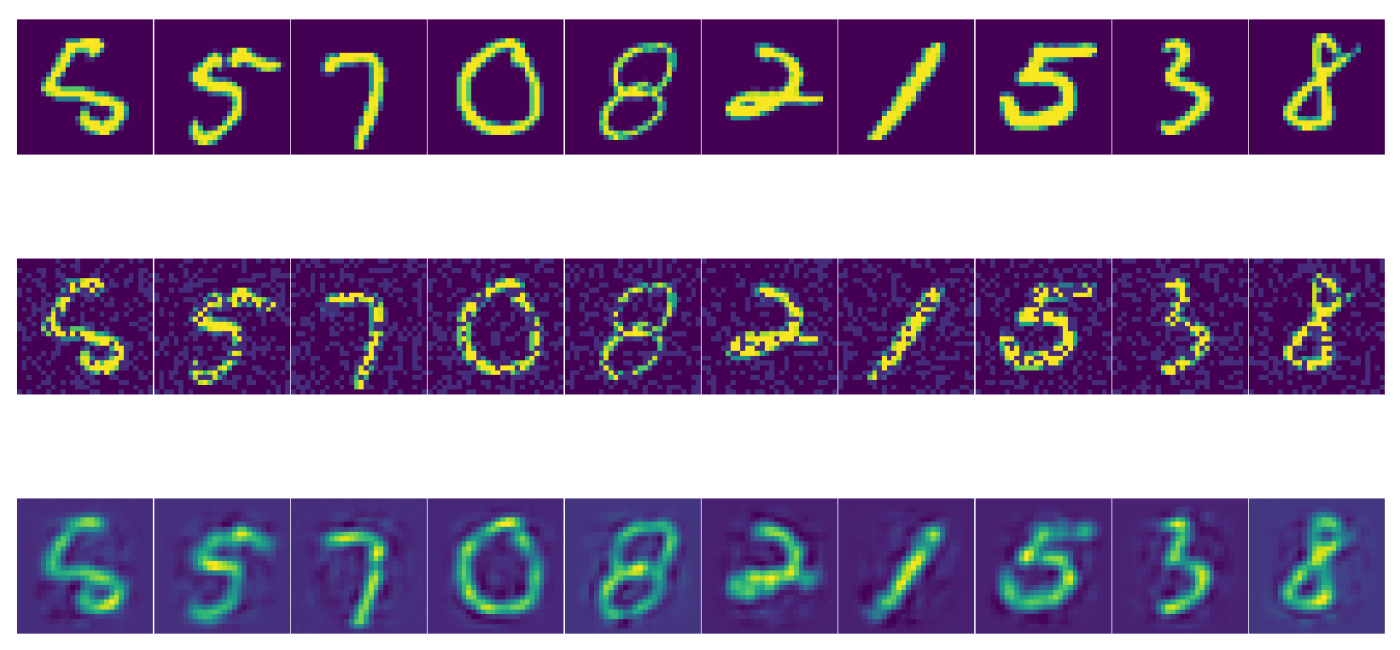

## Bonus task: Stacked Denoising Autoencoder

Implement a stacked denoising autoencoder by following the incremental training procedure mentioned in the lecture slides. Use three layers with 100 neurons each.

## Bonus task: Sparse Autoencoder

Implement an autoencoder with two hidden encoder layers (100 neurons each) and two decoder layers. Use a sigmoid activation for the first encoder layer. Enforce sparsity of activations by adding a penalty term (based on KL-divergence) to the reconstruction loss with r = 0.05.

## Bonus task: k-sparse Autoencoder

Implement a k-sparse autoencoder with one hidden layer (1000 neurons). Use $k = 25$ and $\alpha = 3$. You can use `torch.argsort` to finding the indexes of the $k$ strongest activations and setting the other activations to 0.